In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, Activation, UpSampling1D
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling1D
from keras import  backend as K

In [2]:
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
from sklearn.preprocessing import StandardScaler

def scale_data(trainX, testX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
 flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX.shape))
 flatTestX = flatTestX.reshape((testX.shape))
 return flatTrainX, flatTestX

In [6]:
trainX, testX = scale_data(trainX, testX)

In [7]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [10]:
class_breakdown(y_train)

Class=1, total=870, percentage=16.906
Class=2, total=754, percentage=14.652
Class=3, total=670, percentage=13.020
Class=4, total=900, percentage=17.489
Class=5, total=964, percentage=18.733
Class=6, total=988, percentage=19.199


In [11]:
class_breakdown(y_val)

Class=1, total=356, percentage=16.138
Class=2, total=319, percentage=14.461
Class=3, total=316, percentage=14.325
Class=4, total=386, percentage=17.498
Class=5, total=410, percentage=18.586
Class=6, total=419, percentage=18.994


In [12]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]
n_timesteps, n_features, n_outputs

(128, 9, 6)

In [13]:
def conv_block(in_x, nb_filter, kernel_size):

    x = Conv1D(nb_filter, kernel_size, padding='same')(in_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [14]:
def convolutional_block(in_x, nb_filters, stride):

    F1, F2, F3 = nb_filters

    x = in_x

    x = Conv1D(F1, 3, strides=stride,  padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F2, 3, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F3, 1, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    x1 = Conv1D(F3, 1, strides=stride, padding='same', kernel_initializer="he_normal")(in_x)
    x1 = BatchNormalization()(x1)

    x = add([x, x1])
    x = Activation('relu')(x)

    return x

In [15]:
def attention_branch(in_x, nb_filter, kernel_size):

    x1 = conv_block(in_x, nb_filter, kernel_size)

    x = MaxPooling1D(2)(x1)
    x = conv_block(x, nb_filter, kernel_size)
    x = UpSampling1D(size = 2)(x)

    x2 = conv_block(x, nb_filter, kernel_size)

    if(K.int_shape(x1)!=K.int_shape(x2)):
        x2 = ZeroPadding1D(1)(x2)
        x2 = Cropping1D((1,0))(x2)

    x = add([x1, x2])

    x = conv_block(x, nb_filter, kernel_size)

    x = Conv1D(nb_filter, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    return x

In [16]:
#Residual-Based Temporal Attention Block

def RTA_block(in_x, nb_filter, kernel_size):

    x1 = conv_block(in_x, nb_filter, kernel_size)
    x2 = conv_block(x1, nb_filter, kernel_size)

    attention_map = attention_branch(x1, nb_filter, kernel_size)

    x = multiply([x2, attention_map])
    x = add([x, x1])

    out = conv_block(x, nb_filter, kernel_size)

    return out

In [17]:
def RTA_CNN():

    inputs = Input(shape=(n_timesteps,n_features))

    x = RTA_block(inputs, 16, 32)
    x = MaxPooling1D(4)(x)

    x = RTA_block(x, 32, 16)
    x = MaxPooling1D(4)(x)

    x = RTA_block(x, 64, 9)
    x = MaxPooling1D(2)(x)
    x = RTA_block(x, 64, 9)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.6)(x)

    x = RTA_block(x, 128, 3)
    x = MaxPooling1D(2)(x)
    x = RTA_block(x, 128, 3)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.6)(x)

    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(100,  activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(n_outputs,  activation='softmax')(x)

    model = Model(inputs, x)

    return model

In [18]:
def se_block(in_x, nb_filter):
        squeeze = GlobalAveragePooling1D()(in_x)
        excitation = Dense(units=nb_filter // 2)(squeeze)
        excitation = Activation('relu')(excitation)
        excitation = Dense(units=nb_filter)(excitation)
        excitation = Activation('sigmoid')(excitation)
        excitation = Reshape((1,nb_filter))(excitation)
        scale = multiply([in_x,excitation])
        out = add([in_x, scale])

        return out

In [26]:
def SENET():

    inputs = Input(shape=(n_timesteps,n_features))

    x = Conv1D(16, 32, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 16)
    x = MaxPooling1D(4)(x)

    x = Conv1D(32, 16, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 32)
    x = MaxPooling1D(4)(x)

    x = Conv1D(64, 9, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 64)
    x = MaxPooling1D(2)(x)

    x = Conv1D(64, 9, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 64)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 128)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 128)
    x = MaxPooling1D(1)(x)

    x = Flatten()(x)
    x = Dense(300,  activation='relu')(x)
    x = Dense(n_outputs,  activation='softmax')(x)

    model = Model(inputs, x)

    return model

In [20]:
def RESNET50():

    inputs = Input(shape=(n_timesteps,n_features))

    filter_num = 64

    x = Conv1D(filter_num, 3, strides=2, kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(3, stride=2)(x)

    x = convolutional_block(x, [filter_num, filter_num, filter_num * 4], 4)
    x = identity_block(x, [filter_num, filter_num, filter_num * 4])
    x = identity_block(x, [filter_num, filter_num, filter_num * 4])

    x = convolutional_block(x, [filter_num * 2, filter_num * 2, filter_num * 8], 4)
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])

    x = convolutional_block(x, [filter_num * 4, filter_num * 4, filter_num * 16], 2)
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])

    x = convolutional_block(x, [filter_num * 8, filter_num * 8, filter_num * 32], 2)
    x = identity_block(x, [filter_num * 8, filter_num * 8, filter_num * 32])
    x = identity_block(x, [filter_num * 8, filter_num * 8, filter_num * 32])

    x = GlobalAveragePooling1D()(x)
    x = Dense(500, activation="relu", kernel_initializer="he_normal")(x)
    x = Dense(n_outputs, activation="softmax")(x)

    model = Model(inputs, x)

    return model

In [33]:
import math

def en_loss(y_true, y_pred):

    epsilon = 1.e-7
    gamma = float(0.3)

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    pos_pred = tf.pow(-tf.math.log(y_pred),gamma)
    nag_pred = tf.pow(-tf.math.log(1-y_pred),gamma)
    y_t = tf.multiply(y_true, pos_pred) + tf.multiply(1-y_true, nag_pred)
    en_loss = tf.reduce_mean(y_t)
    return en_loss

In [34]:
from keras.models import Model
model = SENET()
model.summary()
model.compile(optimizer = 'adam', loss=en_loss, metrics = ["accuracy"])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 conv1d_24 (Conv1D)          (None, 128, 16)              4624      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_24 (Ba  (None, 128, 16)              64        ['conv1d_24[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_72 (Activation)  (None, 128, 16)              0         ['batch_normalization_24

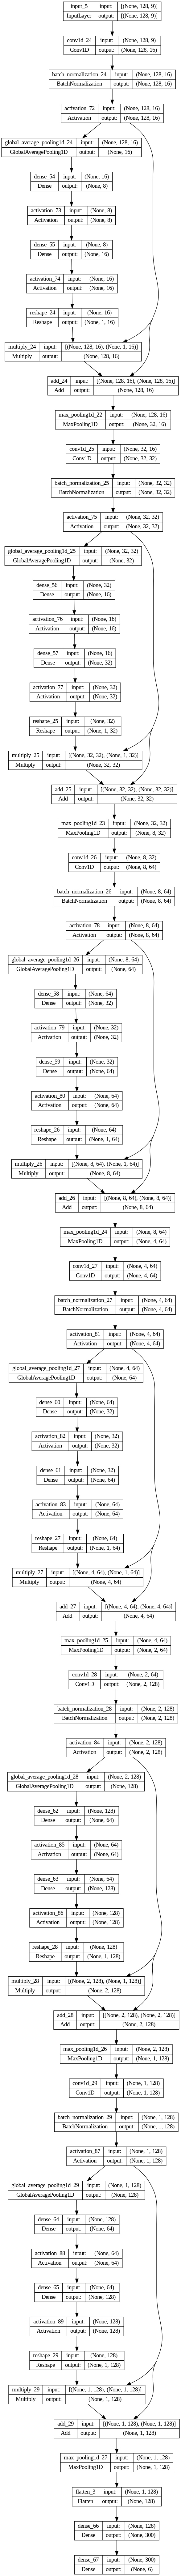

In [35]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [36]:
import math
import time

start = time.time()
model_history=model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32,validation_data=(X_val,y_val_one_hot))


end = time.time()
print(f"{end - start:.5f} sec")

Epoch 1/100
161/161 [==============================] - 22s 34ms/step - loss: 0.1146 - accuracy: 0.8634 - val_loss: 0.1367 - val_accuracy: 0.8146
Epoch 2/100
161/161 [==============================] - 4s 23ms/step - loss: 0.0622 - accuracy: 0.9256 - val_loss: 0.0707 - val_accuracy: 0.9130
Epoch 3/100
161/161 [==============================] - 3s 19ms/step - loss: 0.0544 - accuracy: 0.9357 - val_loss: 0.0875 - val_accuracy: 0.8853
Epoch 4/100
161/161 [==============================] - 5s 30ms/step - loss: 0.0541 - accuracy: 0.9366 - val_loss: 0.0850 - val_accuracy: 0.8944
Epoch 5/100
161/161 [==============================] - 6s 39ms/step - loss: 0.0524 - accuracy: 0.9368 - val_loss: 0.0403 - val_accuracy: 0.9578
Epoch 6/100
161/161 [==============================] - 5s 31ms/step - loss: 0.0483 - accuracy: 0.9431 - val_loss: 0.0414 - val_accuracy: 0.9565
Epoch 7/100
161/161 [==============================] - 8s 47ms/step - loss: 0.0487 - accuracy: 0.9421 - val_loss: 0.0483 - val_accuracy

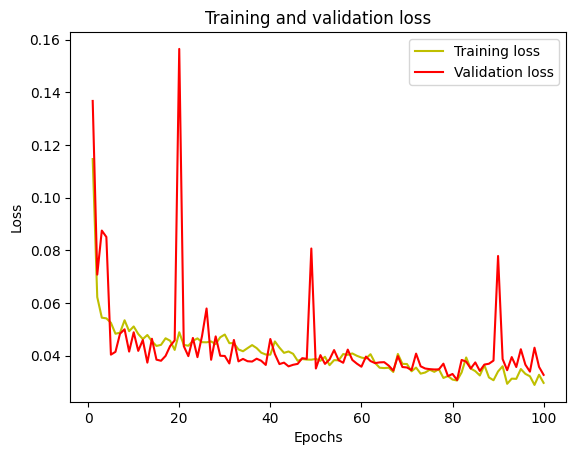

In [37]:
loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

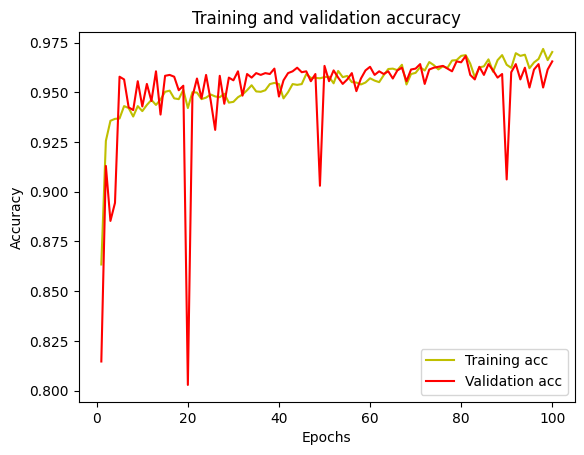

In [38]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 [==============================] - 2s 10ms/step
[[475   0  20   1   0   0]
 [  0 443  28   0   0   0]
 [  1   0 419   0   0   0]
 [  0   1   0 407  83   0]
 [  0   2   0  61 469   0]
 [  0   0   0   0   0 537]]
0.9331523583305056
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       496
           1       0.99      0.94      0.97       471
           2       0.90      1.00      0.94       420
           3       0.87      0.83      0.85       491
           4       0.85      0.88      0.87       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

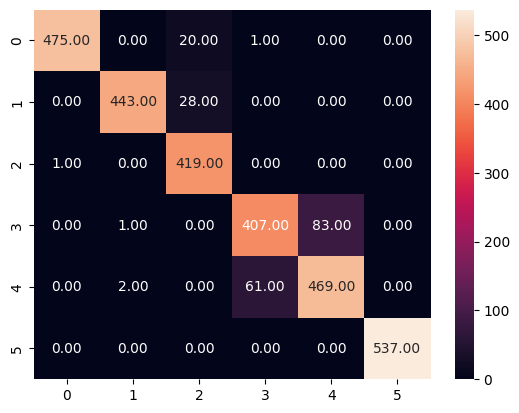

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy = model.predict(testX)
predy = np.argmax(predy, axis=1)

cm= confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(classification_report(testy,predy))
sns.heatmap(cm, annot=True, fmt = '.2f')